# Analysis Grand Challenge of the PHYSLITE data format

This notebook is written as the result of a project of the IRIS-HEP summer fellowship programme. The web page, dedicated to the project, can be found via the [link](https://iris-hep.org/fellows/Denys-Klekots.html).

This code is heavily based on the Analysis Grand Challenge (AGC) of the CMS Open Data $t\bar{t}$. There is a link to the corresponding [GitHub repository](https://github.com/alexander-held/PyHEP-2022-AGC) written by Alexander Held.

Here we will use scientific Python infrastructure, which allows us to read data from the file and further analyse it. The data in high-energy physics is usually stored on an event-by-event basis and contains information on the detected particles. As there is an arbitrary number of particles for each event, we will use the `awkward` Python tools which allow us to handle arrays with an arbitrary length. The PHYSLITE format is stored inside a widely used in higher energy physics `*.root` file format and can be read by using the `coffee` python package. Also, the different events in high-energy physics are independent of each other, which allows for parallel computation and distribution over the cluster, the `dask` python package allows one to handle parallel computations.

In [1]:
import os
import urllib
from pathlib import Path

import awkward as ak
import dask
import dask_awkward as dak
import numpy as np
import hist.dask

import warnings
warnings.filterwarnings("ignore")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools


/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


The PHYSLITE files used for this analysis contain a lot of information, organised in brunches, a description of which can be accessed via the [link](https://atlas-physlite-content-opendata.web.cern.ch/). For the purpose of this specific analysis, a few of them are used and a filter is applied to select used ones.

In [2]:
def filter_name(name):
    return name in [
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        
        "AnalysisJetsAuxDyn.pt",
        "AnalysisJetsAuxDyn.eta",
        "AnalysisJetsAuxDyn.phi",
        "AnalysisJetsAuxDyn.m",
        
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pc",
        "BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu",
        
        "EventInfoAuxDyn.mcEventWeights"
    ]

The code in the cell below will read the data from the file in a function NanoEventsFactory.from_root and produce an awkward array which is named events in this code. Here the PHYSLITESchema is specified to correspond to the format of the data and filter which was discussed above. Also the delayed computation is specified, which make computation in a single go.

In [3]:
mc_file = "root://xcache.af.uchicago.edu:1094//root://eospublic.cern.ch//eos/opendata/atlas/rucio/mc20_13TeV/DAOD_PHYSLITE.37621215._000011.pool.root.1"

# mc_file = "https://cernbox.cern.ch/remote.php/dav/public-files/BPIO76iUaeYuhaF/DAOD_PHYSLITE.37233417._000052.pool.root.1"

# # download for subsequent use
# local_file_name = "ttbar.root"

# if not os.path.exists(local_file_name):
#     urllib.request.urlretrieve(mc_file, filename=local_file_name)

events = NanoEventsFactory.from_root(
    {mc_file: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    delayed=True,
    uproot_options=dict(filter_name=filter_name),
).events()

### B-tagging discriminant

The DL1 b-tagging flavour tagging algorithm is used for pre-analysis of data stored in PHYSLITE format and used in this analysis. The output of the DL1 algorithm is the $p_b$ $p_c$ and $p_u$ variables that are combined by the following formula to define the final discriminant on b-tagging

$$
D_{DL1} = log \left( \frac{p_b}{f_c \cdot p_c + (1-f_c) \cdot p_u} \right)
$$ 

The $p_b$ $p_c$ and $p_u$ are stored in the file under field names `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb`, `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pb` and `BTagging_AntiKt4EMPFlowAuxDyn.DL1dv01_pu` respectively. For more information about discriminant value please refer to the following [link](https://ftag.docs.cern.ch/recommendations/algs/2019-recommendations/#algorithm-structure) (Please note that the CERN account might be needed). $f_c$ is the constant which equal to $f_c = 0.018$ in this analysis.

The jet is considered as b-tagged if the $D_{DL1}$ variable is above threshold. The threshold value of 2.456 was used here, which correspond to efficiency of 77%. Refer to the [link](https://ftag.docs.cern.ch/recommendations/algs/r22-preliminary/#working-point-definition-for-dl1dv01) for more information (please note that CERN account might be needed to access).

In [4]:
def calculate_jets_btagDL1d(events):
    
    BTagging = events.BTagging_AntiKt4EMPFlow
    
    f_c = 0.018
    DDL1 = BTagging.DL1dv01_pb/(f_c*BTagging.DL1dv01_pc + (1-f_c)*BTagging.DL1dv01_pu)

    DDL1 = np.log(DDL1)

    return DDL1

## Events selection

The point of this analysis grand challenge is to make analysis of the t quark pairs. Specifically here is selected events which has at least four quark jets, at least two of tham is b-tagged, and exactly one charged lepton. The additional selection on the transverse momentum and the $\eta$ parameter of the leptons and jets are applied.

The schematic view of event with four jets is presented on the following image. Here who b quarks are forming jets that is b-tagged. The who another quarks (which coming from W boson decay) is not necessary b-tagged. The charged lepton is also coming from decay of other W boson, and the neutrino is not detected in this experiment.

<div>
<img src="utils/ttbar.png" width="500"/>
</div>

The source of the image is the [AGC](https://github.com/alexander-held/PyHEP-2022-AGC/blob/main/talk.ipynb) notebook by Alexander Held.


### Notes on b-tagging variables in code

At the moment of writing of this code, the jets information are stored in the file under `AnalysisJetsAuxDyn` brunch name, at the same time the variables, used for calculation of the b-tagging discriminant, are stored in the brunch named `BTagging_AntiKt4EMPFlowAuxDyn`. In the future it might be changes in the `PHYSLITESchema` to link the b-tagging infro into jet's branch, but as for now we did in manually. The usage of the b-tagging discriminant under the jets brunch is much more conveniant.

### Trijet mass

In the function below all the jets (which pass the present) in each event are combined in all possible groups of three, after which the group with the largest b-tagging value is selected and the invariant mass of which is calculated.


In [5]:
def calculate_trijet_mass_and_ev_filter(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electrons[events.Electrons.pt > 30 & (np.abs(events.Electrons.eta) < 2.1)]
    selected_muons = events.Muons[events.Muons.pt > 30 & (np.abs(events.Muons.eta) < 2.1)]
    
    # calculate tagging variable and attach it to jets(which pass the present)
    jets = events.Jets
    jets["btagDL1d"] = calculate_jets_btagDL1d(events)
    selected_jets = jets[events.Jets.pt > 25 & (np.abs(events.Jets.eta) < 2.4)] 
    
    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 2.456
    event_filters = event_filters & (ak.sum(selected_jets.btagDL1d > B_TAG_THRESHOLD, axis=1) >= 2)
    
    # apply filters
    selected_jets = selected_jets[event_filters]
    
    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagDL1d, np.maximum(trijet.j2.btagDL1d, trijet.j3.btagDL1d))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
        
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    
    
    return ak.flatten(trijet_mass), event_filters

In [6]:
reconstructed_top_mass, _ = calculate_trijet_mass_and_ev_filter(events)
hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375, label="$m_{bjj} [GeV]$").Double().fill(reconstructed_top_mass/1000)

The code for processing the data written above is not executed until the `.compute()` method of the `hist_reco_mtop` is not called. This was discussed above when one mentioned delayed computation in the parameters of `NanoEventsFactory.from_root()` function. Such a delayed approach allows highly improved efficiency of calculations.

(0.0, 375.0)

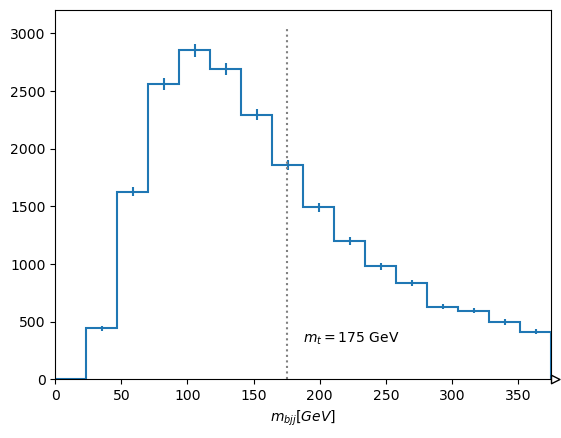

In [7]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

# and annotate the visualization
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175, 0, ax.get_ylim()[1], colors=["grey"], linestyle="dotted") 
ax.text(0.5, 0.1, "$m_{t} = 175$ GeV", transform = ax.transAxes)
ax.set_xlim([0, 375])

# Distributed computations

Now we will move to the distributed computations. The code below applies the same approach to the selection of the data and calculation of the mass of the trijets. The further code uses multiple PHYSLITE files which have the same structure of branches and are processed in a parallel way, after which the results are merged in the final histogram.

In [8]:
from dask.distributed import Client

# Set up the client distribution calculation for coffea-opendata.casa. Change the URL for UChicago
client = Client("tls://localhost:8786")

The files used for distributed calculations and their metadata are specified in the cell below. This particular case uses Monte Carlo generated data.

In [ ]:
import file_utils

LUMINOSITY = 36100 

fileset = {
"singletop_schan_lept_top"  : 
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_singletop_schan_lept_top},
            'metadata': {"cross-section": 2.027, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.017, 
                         "sum-of-weights":365019.0806794167, 
                         "process-label":"singletop_schan_lept"},
            },
"singletop_schan_lept_antitop":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_singletop_schan_lept_antitop},
            'metadata': {"cross-section": 1.2674, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.0167, 
                         "sum-of-weights":152312.88860154152, 
                         "process-label":"singletop_schan_lept"},
            },
"tchan_BW50_lept_top":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_tchan_BW50_lept_top},
            'metadata': {"cross-section": 36.996, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.1935, 
                         "sum-of-weights":124412662.10998064, 
                         "process-label":"tchan_BW50_lept"},
            },
"tchan_BW50_lept_antitop":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_tchan_BW50_lept_antitop},
            'metadata': {"cross-section": 22.173, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.1849, 
                         "sum-of-weights":44399910.88976225, 
                         "process-label":"tchan_BW50_lept"},
            },
"tW_dyn_DR_incl_antitop":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_tW_dyn_DR_incl_antitop},
            'metadata': {"cross-section": 35.972, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.0, 
                         "sum-of-weights":96216887.40345384, 
                         "process-label":"tW_dyn_DR_incl"},
            },
"tW_dyn_DR_incl_top":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_tW_dyn_DR_incl_top},
            'metadata': {"cross-section": 36.003, 
                         "filter-efficiency": 1.0, 
                         "k-factor": 1.0, 
                         "sum-of-weights":95054189.43354416, 
                         "process-label":"tW_dyn_DR_incl"},
            },
"ttbar_hdamp258p75_nonallhad":
            {
            'files': {name:'CollectionTree' for name in file_utils.filenames_ttbar_hdamp258p75_nonallhad},
            'metadata': {"cross-section": 729.77, 
                         "filter-efficiency": 0.5437965, 
                         "k-factor": 1.139756362, 
                         "sum-of-weights": 24014984445.81677, 
                         "process-label":"ttbar_hdamp258p75_nonallhad"},
            }
}      
    
samples, _ = dataset_tools.preprocess(fileset)

OSError: File did not open properly: [ERROR] Operation expired

The cell below defines the code for the delayed calculation of the trijet mass. As there are data used from the Monte Carlo simulation one knows for certain the specific physical process of the t-quark decay. To present data on the same histogram one needs to do rescaling as there is an arbitrary number of events generated for a specific event.

In [ ]:
def create_histogram(events):

    reconstructed_top_mass, event_filters = calculate_trijet_mass_and_ev_filter(events)
        
    cross_section = events.metadata["cross-section"]
    filter_efficiency = events.metadata["filter-efficiency"]
    k_factor = events.metadata["k-factor"]
    sum_of_weights = events.metadata["sum-of-weights"]
    process_label = events.metadata["process-label"]
        
    mc_weight = events.EventInfo.mcEventWeights[:, 0][event_filters]
    
    lumi_weight = LUMINOSITY * cross_section * k_factor * filter_efficiency / sum_of_weights
        
    
    hist_reco_mtop = (hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
                     .StrCat([], name="process", label="Process", growth=True)
                     .Weight()
                     .fill(reconstructed_top_mass/1000, weight=lumi_weight*mc_weight, process=process_label) )
    
    return hist_reco_mtop

The cell below attaches the files we prepared for parallel analysis to the dedicated function, `create_histogram` in our case. There we also specify branch filters and usage of `PHYSLITESchema`

In [ ]:
tasks = dataset_tools.apply_to_fileset(create_histogram, 
                                       samples, 
                                       schemaclass=PHYSLITESchema,
                                       uproot_options=dict(filter_name=filter_name)
                                      )

The cell below runs computations for parallel processing of multiple files, which were delayed.

In [ ]:
%%time

# execute
(out, ) = dask.compute(tasks)

And finally making the histogram from the distributed computing

In [ ]:
full_histogram_hist_mtop = sum([v for v in out.values()])

artists = full_histogram_hist_mtop.stack("process").plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)